In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from ocpa.objects.log.importer.ocel import factory as ocel_import_factory
import seaborn as sns
import pandas as pd
from src.helpers.dataset import get_selected_dataset, log_path_for_dataset
from matplotlib import pyplot as plt

In [10]:
dataset = get_selected_dataset()

In [4]:
ocel = ocel_import_factory.apply(log_path_for_dataset(dataset))

In [6]:
# count the number of total events
print('Number of events', len(ocel.log.log))
# count the number of unique activities
print('Number of activities', len(ocel.obj.activities))
# count the number of object types
print('Object types', ocel.object_types)
# count the number of total objects
print('Number of objects', {ot: len(ocel.obj.ot_objects[ot]) for ot in ocel.object_types})
# count the number of total objects
print('Number of total objects', sum([len(ocel.obj.ot_objects[ot]) for ot in ocel.object_types]))
# count the number of unique resources
print('Number of resources', ocel.log.log['event_resource'].nunique())
# First and last event
print('First event', ocel.log.log['event_timestamp'].min())
print('Last event', ocel.log.log['event_timestamp'].max())
# count the number of process executions
print('Number of process executions', len(ocel.process_executions))
# count the number of variants
print('Number of variants', len(ocel.variants))

Number of events 2391
Number of activities 11
Object types ['order', 'item', 'delivery']
Number of objects {'order': 199, 'item': 398, 'delivery': 199}
Number of total objects 796
First event 2022-10-20 16:56:19.864004
Last event 2022-12-18 12:23:32.871959
Number of process executions 48
Number of variants 12


In [7]:
# graph the distribution of the number of events per process execution
data = list(map(len, ocel.process_executions))
data = pd.DataFrame(data, columns=['Number of events'])

In [8]:
data.describe()

,Number of events
count,48.000000
mean,49.812500
std,262.436672
min,9.000000
25%,9.000000
50%,11.500000
75%,14.000000
max,1830.000000


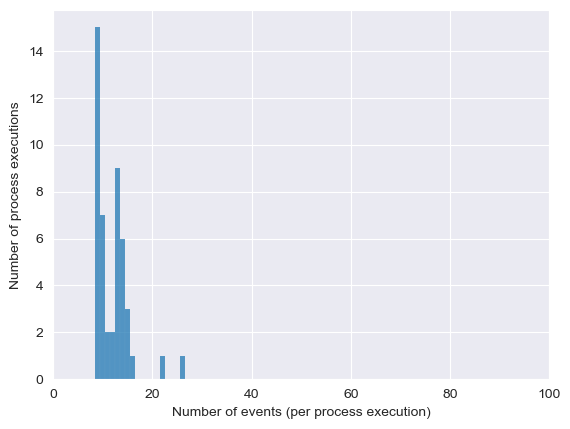

In [11]:
g = sns.histplot(data, x='Number of events', discrete=True)
g.set(xlabel='Number of events (per process execution)', ylabel='Number of process executions')
# Limit the x axis to 1000
g.set_xlim(0, 100)
plt.savefig('process-execution-length-distribution_100.svg')
plt.savefig('process-execution-length-distribution_100.pdf')

In [12]:
# Calculate the throughput time of each process execution
throughput_times = []
for pe in ocel.process_executions:
    es = list(pe)
    es.sort()
    throughput_times.append(ocel.get_value(max(es), 'event_timestamp') - ocel.get_value(min(es), 'event_timestamp'))

In [13]:
data = pd.Series(throughput_times)
data.describe()

count                            48
mean     28 days 14:07:03.442702687
std      16 days 01:37:38.864548785
min          0 days 08:56:22.000988
25%         15 days 01:53:25.005976
50%      27 days 17:34:02.004476500
75%      41 days 18:38:38.755468500
max         58 days 19:17:14.007955
dtype: object

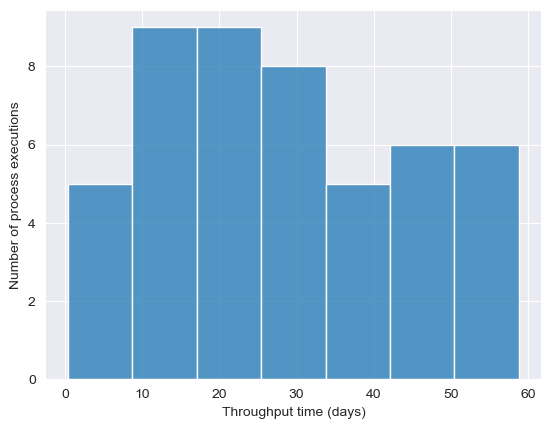

In [14]:
# Plot the throughput time as a histplot (in days)
g = sns.histplot(data=data / pd.Timedelta(days=1))
g.set(xlabel='Throughput time (days)', ylabel='Number of process executions')
plt.savefig('throughput-time-distribution.svg')

In [15]:
# Mean number of objects per event
ots = ocel.object_types
ocel.log.log['object_count'] = ocel.log.log[ots].apply(lambda x: x.map(len).sum(), axis=1)

In [16]:
ocel.log.log['object_count'].describe()

count    2391.000000
mean        1.832288
std         0.986042
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max         3.000000
Name: object_count, dtype: float64

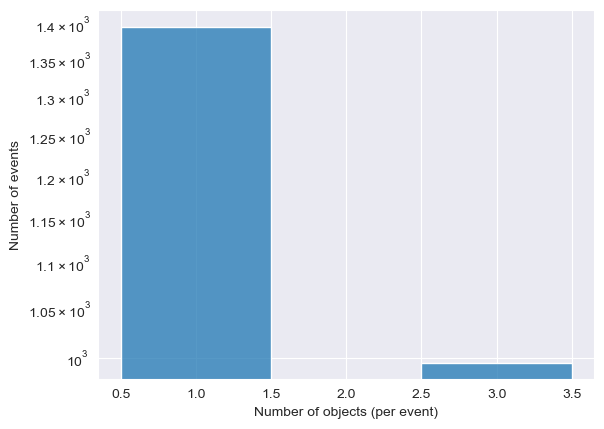

In [17]:
# Plot the distribution of the number of objects per event as a boxplot
data = pd.DataFrame(ocel.log.log['object_count'].to_numpy(), columns=['Number of objects'])
g = sns.histplot(data, x='Number of objects', discrete=True)
g.set(xlabel='Number of objects (per event)', ylabel='Number of events')
g.set_yscale('log')
plt.savefig('event-object-count-distribution.svg')
plt.savefig('event-object-count-distribution.pdf')

In [ ]:
# Print activities of process executions with 3 or less events
timestamps = []
for pe in ocel.process_executions:
    if len(pe) <= 5:
        es = list(pe)
        es.sort()
        timestamps.append(ocel.get_value(max(es), 'event_timestamp'))

In [ ]:
timestamps.sort()
plt.plot(timestamps)
plt.show()

In [ ]:
from datetime import datetime

first_activities = []
first_timestamps = []
for p in ocel.process_executions:
    first_event_id = min(p)
    first_activities.append(ocel.get_value(first_event_id, 'event_activity'))
    first_timestamps.append(ocel.get_value(first_event_id, 'event_timestamp'))

In [ ]:
# value counts of the first activities
print('Total number of first activities', len(first_activities))
pd.Series(first_activities).value_counts()

In [ ]:
# Plot the timestamps of the first events
first_timestamps.sort()
plt.plot(first_timestamps)
plt.show()